# <center> NLP - Disaster Tweets </center>

### 1. Load data

#### 1.1 Install packages

In [1]:
# !pip install geopy
# !pip install folium
# !pip install transformers
# !pip install ipywidgets
# !pip install widgetsnbextension

In [2]:
# nltk.download('wordnet')

In [24]:
# import nltk
# nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

#### 1.2 Imports 

In [1]:
import numpy as np
import pandas as pd 

#sklearn
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics
from sklearn.metrics import (precision_score, recall_score, f1_score, classification_report, accuracy_score)

# text processing
import re
import string

import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# visualizations
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as py

# map
import folium 
from folium import plugins 
import plotly.figure_factory as ff
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Tensorflow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.layers import (LSTM, Embedding, BatchNormalization, Dense, TimeDistributed, Dropout,
                                                            Bidirectional, Flatten, GlobalMaxPool1D, Input, GlobalAveragePooling1D)

# BERT
import transformers
from transformers import TFBertModel, BertTokenizer
from tokenizers import BertWordPieceTokenizer
from tqdm.notebook import tqdm

# XGBoost
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [5]:
df_train

id            keyword         location  \
0         1         earthquake              NaN   
1         4      forest%20fire           Canada   
2         5         evacuation              NaN   
3         6          wildfires  California, USA   
4         7          wildfires      Alaska, USA   
...     ...                ...              ...   
7608  10869  bridge%20collapse              NaN   
7609  10870           wildfire       California   
7610  10871            volcano      Hawaii, USA   
7611  10872           collided         Portugal   
7612  10873           wildfire       California   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

### 2. Data Preparation

#### 2.1 Extract URLs and numbers in separate columns

In [3]:
#URL
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)' 
df_train['URL'] = df_train.text.str.extract(pattern, expand=True)
print(df_train)

         id            keyword         location  \
0         1         earthquake              NaN   
1         4      forest%20fire           Canada   
2         5         evacuation              NaN   
3         6          wildfires  California, USA   
4         7          wildfires      Alaska, USA   
...     ...                ...              ...   
7608  10869  bridge%20collapse              NaN   
7609  10870           wildfire       California   
7610  10871            volcano      Hawaii, USA   
7611  10872           collided         Portugal   
7612  10873           wildfire       California   

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as 

In [4]:
# numbers
p = r'([0-9]+)'
df_train['number'] = df_train.text.str.extract(p, expand=True)
print(df_train)

         id            keyword         location  \
0         1         earthquake              NaN   
1         4      forest%20fire           Canada   
2         5         evacuation              NaN   
3         6          wildfires  California, USA   
4         7          wildfires      Alaska, USA   
...     ...                ...              ...   
7608  10869  bridge%20collapse              NaN   
7609  10870           wildfire       California   
7610  10871            volcano      Hawaii, USA   
7611  10872           collided         Portugal   
7612  10873           wildfire       California   

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as 

In [5]:
df_train.sample(10)

id       keyword                 location  \
1519   2193  catastrophic             Planet Earth   
1652   2387     collapsed  I'm standing behind you   
4489   6385     hurricane                      NaN   
6186   8831        sirens           Los Angles, CA   
1718   2479      collided                      NaN   
105     153    aftershock                      304   
6281   8972         storm                  Alberta   
3783   5373  fire%20truck           Plain O' Texas   
7168  10272    war%20zone       We're All Mad Here   
4392   6244     hijacking                 Mongolia   

                                                   text  target  \
1519  Learning from the Legacy of a Catastrophic Eru...       1   
1652       @rokiieee_ the game has officially collapsed       0   
4489  You messed up my feeling like a hurricane dama...       0   
6186  What's going on in Hollywood? #abc7eyewitness ...       0   
1718  My @MLG and food worlds have collided in this ...       0   
105   'There is no victory at bargain basement price...       0   
6281  'Calgarians stunned by storm insurance compani...       1   
3783  @BrookTekle_ didn't look like a murder scene j...       1   
7168   Packing for CT aka my room looks like a war zone       0   
4392  #hot  Funtenna: hijacking computers to send da...       1   

                          URL number  
1519   http://t.co/t344PhNpy9    344  
1652                      NaN    NaN  
4489                      NaN    NaN  
6186                      NaN      7  
1718  https://t.co/2SnyGHaiVs      2  
105                       NaN    NaN  
6281   http://t.co/fkFa9vSssZ      9  
3783                      NaN      1  
7168                      NaN    NaN  
4392   http://t.co/J2aQs5loxu   2015

#### 2.2 Keep http in text

In [5]:
df_train['text'] = df_train['text'].str.split('://').str[0]
df_train['text'].iloc[76]

"'By accident' they knew what was gon happen https"

In [10]:
#http_str = df_train['text']
for char in df_train['text']:
    df_train['text'] = df_train['text'].str.split('http:')[1].lstrip().split(' ')[0]
#df_train['text'] = df_train['text'].str.extract(http_str)
print(df_train['text'])

AttributeError: 'list' object has no attribute 'lstrip'

#### 2.3 Prepare keywords column

In [6]:
# might be replaced with ' ' a white space
df_train['keyword']=df_train['keyword'].str.replace('%20', '_')

In [7]:
# might be replaced with ' ' a white space
df_train['keyword']=df_train['keyword'].str.replace('%', '_')

In [8]:
df_train.head()

id      keyword         location  \
0   1   earthquake              NaN   
1   4  forest_fire           Canada   
2   5   evacuation              NaN   
3   6    wildfires  California, USA   
4   7    wildfires      Alaska, USA   

                                                text  target  URL number  
0  Our Deeds are the Reason of this #earthquake M...       1  NaN    NaN  
1             Forest fire near La Ronge Sask. Canada       1  NaN    NaN  
2  All residents asked to 'shelter in place' are ...       1  NaN    NaN  
3  13,000 people receive #wildfires evacuation or...       1  NaN     13  
4  Just got sent this photo from Ruby #Alaska as ...       1  NaN    NaN

### 2. EDA

#### 2.1 Checkout a disaster tweet

In [14]:
d_t = df_train[df_train['target'] == 1]['text']
for i in range(1,5):
    print(d_t[i])

Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


#### 2.2 Checkout a non disaster tweet

In [15]:
nd_t = df_train[df_train['target'] != 1]['text']
print(nd_t.head(5))

15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
Name: text, dtype: object


#### 2.3 Plot null values in train & test dataset

In [16]:
df_temp = df_train['target']==0

In [17]:
df_temp=df_train[df_train['target']==0] 
loc_null_values_by_target = df_temp['location'].isnull().sum()
keyword_null_values_by_target =  df_temp['keyword'].isnull().sum()
print(f"Null values for location for fake disasters: {loc_null_values_by_target}, null keywords for fake disaster: {keyword_null_values_by_target}")

Null values for location for fake disasters: 1459, null keywords for fake disaster: 0


In [18]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Keyword - Fake Disasters Dataset'],
    y=[keyword_null_values_by_target],
    name='Keyword',
    text=[keyword_null_values_by_target],
    textposition='auto',
    marker = {'color' : 'salmon'}
))
fig.add_trace(go.Bar(
    x=['Location - Fake Disasters Dataset'],
    y=[loc_null_values_by_target],
    name='Location',
    text=[loc_null_values_by_target],
    textposition='auto',
    marker = {'color' : 'cadetblue'}
))

fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Missing values of keyword & location for fake disasters</span>', 
)
fig.show()

In [19]:
loc_null_values = df_train['location'].isnull().sum()
loc_null_values_test = df_test['location'].isnull().sum()

In [20]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Location - Train Dataset'],
    y=[loc_null_values],
    name='Location',
    text=[loc_null_values],
    textposition='auto',
    marker = {'color' : 'cadetblue'}
))
fig.add_trace(go.Bar(
    x=['Location - Test Dataset'],
    y=[loc_null_values_test],
    name='Location',
    text=[loc_null_values_test],
    textposition='auto',
    marker = {'color' : 'salmon'}
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Missing values of location</span>', 
)
fig.show()

#### 2.4 Show the lenght of a tweet

In [9]:
df_train['text_len'] = df_train['text'].apply(lambda x: len(x.split(' ')))

In [10]:
df_train.head()

id      keyword         location  \
0   1   earthquake              NaN   
1   4  forest_fire           Canada   
2   5   evacuation              NaN   
3   6    wildfires  California, USA   
4   7    wildfires      Alaska, USA   

                                                text  target  URL number  \
0  Our Deeds are the Reason of this #earthquake M...       1  NaN    NaN   
1             Forest fire near La Ronge Sask. Canada       1  NaN    NaN   
2  All residents asked to 'shelter in place' are ...       1  NaN    NaN   
3  13,000 people receive #wildfires evacuation or...       1  NaN     13   
4  Just got sent this photo from Ruby #Alaska as ...       1  NaN    NaN   

   text_len  
0        13  
1         7  
2        22  
3         9  
4        17

#### 2.5 Train dataset distribution by Target

In [23]:
balance_counts = df_train.groupby('target')['target'].agg('count').values
balance_counts

array([4343, 3270], dtype=int64)

In [24]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Fake'],
    y=[balance_counts[0]],
    name='Fake',
    text=[balance_counts[0]],
    textposition='auto',
    marker = {'color' : 'salmon'}
))
fig.add_trace(go.Bar(
    x=['Real disaster'],
    y=[balance_counts[1]],
    name='Real disaster',
    text=[balance_counts[1]],
    textposition='auto',
    marker = {'color' : 'cadetblue'}
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

#### 2.6 Target distribution in keywords

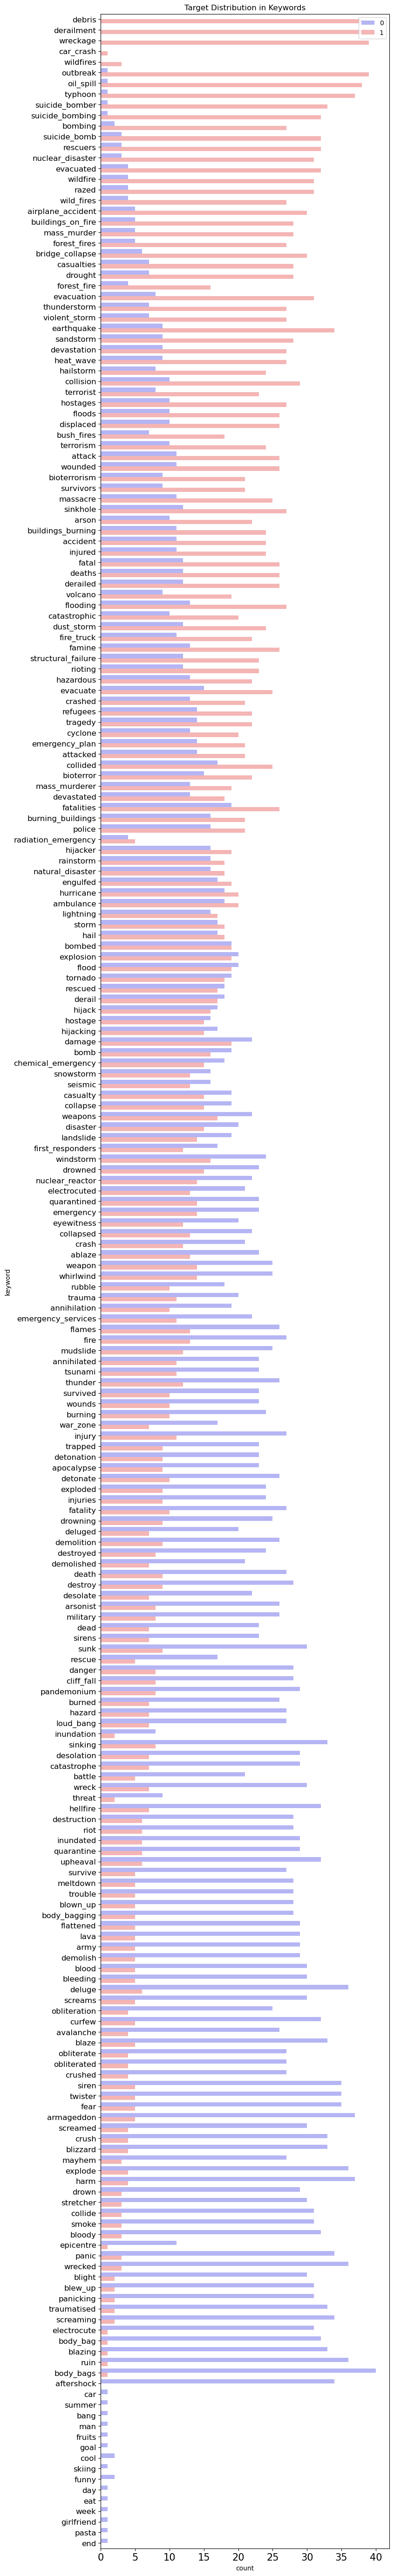

In [25]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'], palette='bwr')

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

#### 2.7 Word cloud of disaster and non-disaster tweets to see most repeating word

Text(0.5, 1.0, 'Non Disaster tweets')

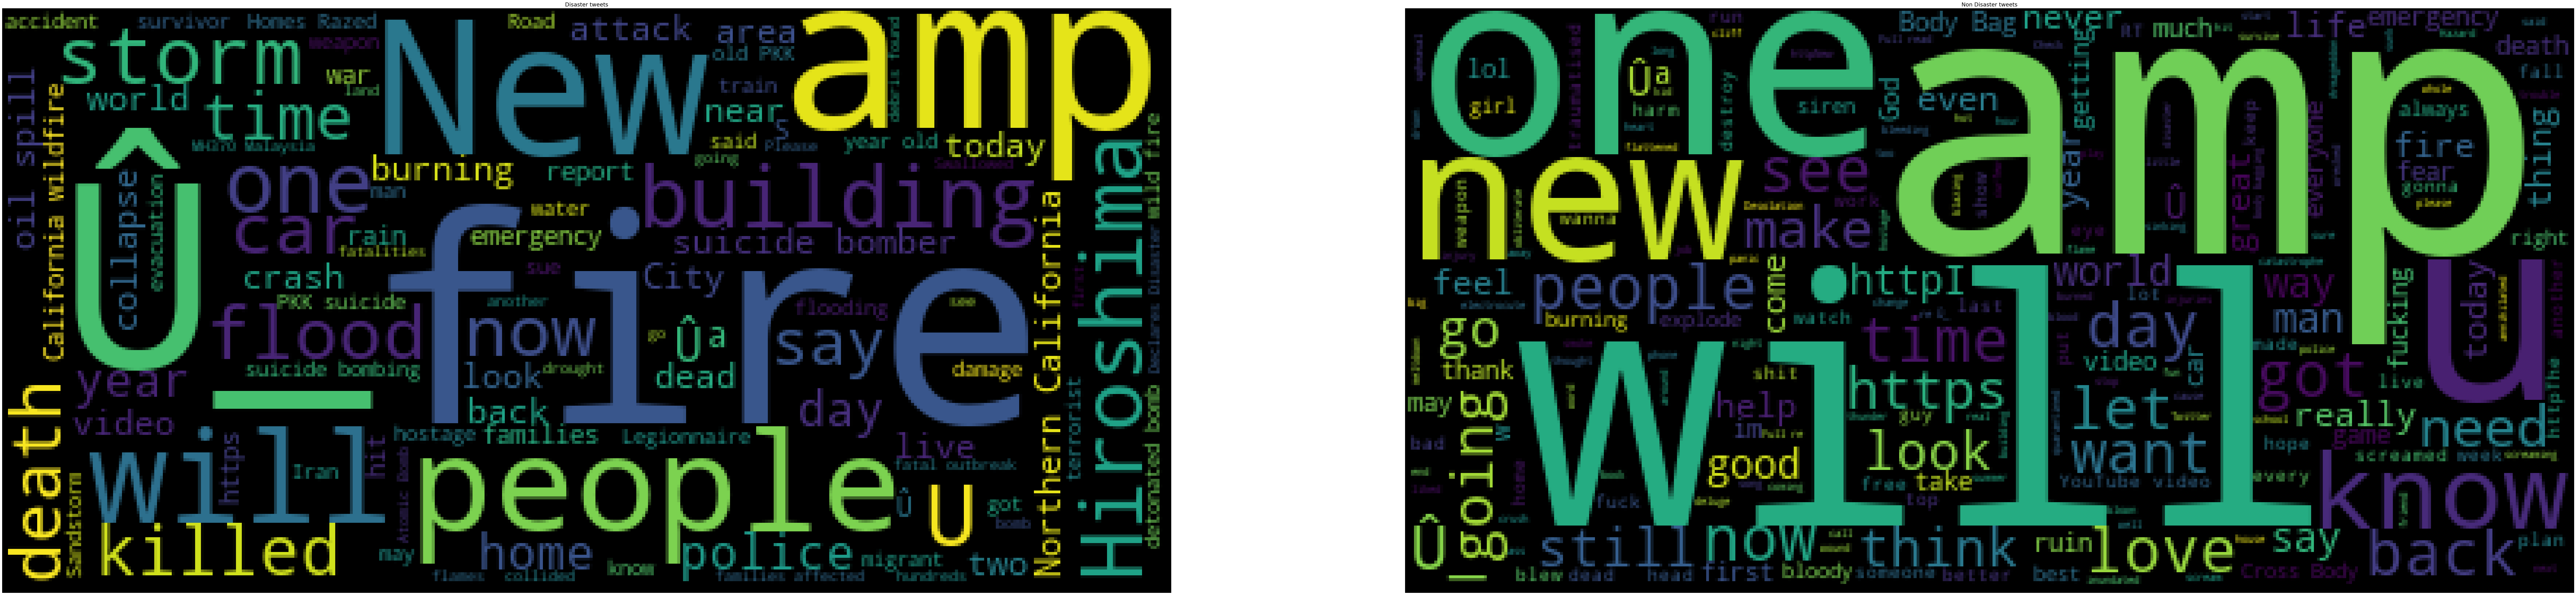

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [150, 50])

wc1 = WordCloud().generate(''.join(d_t))
ax1.imshow(wc1)
ax1.axis('off')
ax1.set_title('Disaster tweets', fontsize = 18)

wc2 = WordCloud().generate(''.join(nd_t))
ax2.imshow(wc2)
ax2.axis('off')
ax2.set_title('Non Disaster tweets', fontsize = 18)

#### 2.8 Top 10 keywords in the train dataset

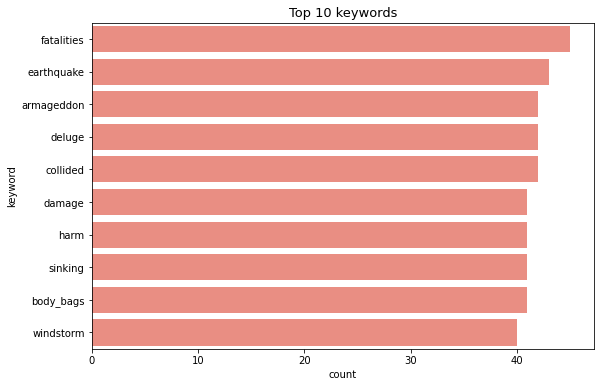

In [27]:
plt.figure(figsize=(9,6))
sns.countplot(y = df_train.keyword, order= df_train.keyword.value_counts().iloc[:10].index, color='salmon')
plt.title('Top 10 keywords', fontsize=13)
plt.show()

#### 2.9 Visualize tweets by location on a map

In [29]:
df = df_train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="DC2-NLP-Disaster Tweets")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
California
California, USA
Worldwide
Australia
Chicago, IL
Everywhere
New York, NY
United Kingdom


In [30]:
map1 = folium.Map(location=[10.0, 10.0], tiles='openstreetmap', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

### 3. Data Preprocessing

#### 3.1 Clean the tweets

Make text lowercase, remove text in square brackets,remove linkemove punctuation and remove words containing numbers.

In [11]:
def clean_text(text):
    # Convert to lower
    text = text.lower()
    # remove html tags
    text = re.sub(r'\[.*?\]',' ', text)
    # remove link
    text = re.sub(r'https?://\S+|www\.\S+',' ', text)
    #remove line breaks
    text = re.sub(r'\n',' ',text)
    #Remove trailing spaces, tabs
    text  = re.sub('\s+',' ',text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Remove special characters
    text = re.sub('\w*\d\w*','',text)
    return text

# Apply clean function on random train string 
test_str = df_train.loc[417, 'text']
print('Original text: '+test_str+'\n')
print('Text after cleaning: '+clean_text(test_str))
df_train['text'] = df_train['text'].apply(clean_text)
df_train['text'].head(5)

Original text: Arson suspect linked to 30 fires caught in Northern California http

Text after cleaning: arson suspect linked to  fires caught in northern california http


0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

#### 3.2 Stopwords

In [12]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c', 'amp']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_train.head(10)

id      keyword         location  \
0   1   earthquake              NaN   
1   4  forest_fire           Canada   
2   5   evacuation              NaN   
3   6    wildfires  California, USA   
4   7    wildfires      Alaska, USA   
5   8    wildfires  California, USA   
6  10        flood              USA   
7  13         fire              NaN   
8  14   evacuation              NaN   
9  15      tornado              NaN   

                                                text  target  URL number  \
0       deeds reason earthquake may allah forgive us       1  NaN    NaN   
1              forest fire near la ronge sask canada       1  NaN    NaN   
2  residents asked shelter place notified officer...       1  NaN    NaN   
3   people receive wildfires evacuation orders ca...       1  NaN     13   
4  got sent photo ruby alaska smoke wildfires pou...       1  NaN    NaN   
5  rockyfire update  california hwy  closed direc...       1  NaN     20   
6  flood disaster heavy rain causes flash floodin...       1  NaN    NaN   
7                            top hill see fire woods       1  NaN    NaN   
8  theres emergency evacuation happening building...       1  NaN    NaN   
9                         afraid tornado coming area       1  NaN    NaN   

   text_len  
0        13  
1         7  
2        22  
3         9  
4        17  
5        18  
6        14  
7        15  
8        12  
9        10

#### 3.3 Tokenization

In [13]:
tokenizer = RegexpTokenizer(r'\w+')

## Applying tokenization function on train sets
df_train['text'] = df_train['text'].map(tokenizer.tokenize)

## checkout train dataset tokens
df_train['text'].head(5)

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

#### 3.4 Lemmatization

In [16]:
def lem_words(t):
    l = WordNetLemmatizer()
    return [l.lemmatize(w) for w in t]

df_train['text'] =df_train['text'].apply(lambda x: lem_words(x))
## checkout train dataset with lemmatized words
df_train['text'].head(5)

0    [deed, reason, earthquake, may, allah, forgive...
1        [forest, fire, near, la, ronge, sask, canada]
2    [resident, asked, shelter, place, notified, of...
3    [people, receive, wildfire, evacuation, order,...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

#### 3.5 Transform tokens into sentences 

In [17]:
def combine_txt(t):
    c  = ' '.join(t)
    return c

df_train['text'] =df_train['text'].apply(lambda x: combine_txt(x))

## checkout train dataset with lemmatized words
df_train['text'].head(5)

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

#### 3.6 Wordcloud on the cleaned text

In [36]:
tr = df_train[df_train['target'] == 1]['text']
for i in range(1,5):
    print(tr[i])

forest fire near la ronge sask canada
resident asked shelter place notified officer evacuation shelter place order expected
people receive wildfire evacuation order california
got sent photo ruby alaska smoke wildfire pours school


In [37]:
non = df_train[df_train['target'] != 1]['text']
print(non.head(5))

15          whats man
16         love fruit
17      summer lovely
18           car fast
19    goooooooaaaaaal
Name: text, dtype: object


Text(0.5, 1.0, 'Non Disaster tweets')

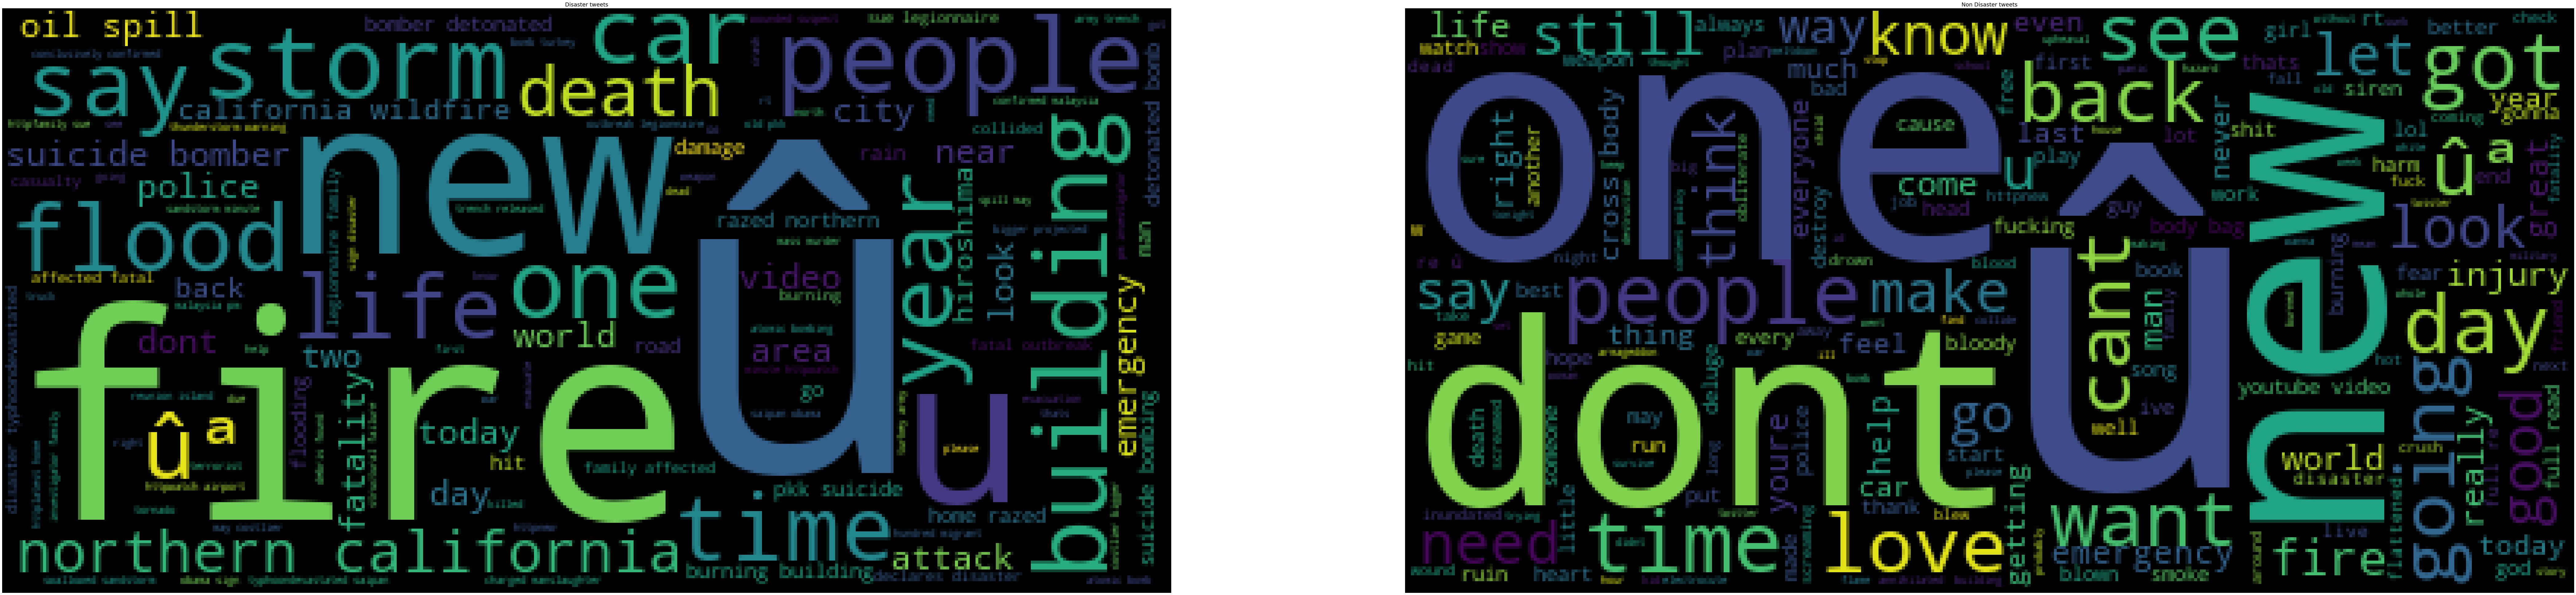

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [150, 50])

wc1 = WordCloud().generate(''.join(tr))
ax1.imshow(wc1)
ax1.axis('off')
ax1.set_title('Disaster tweets', fontsize = 18)

wc2 = WordCloud().generate(''.join(non))
ax2.imshow(wc2)
ax2.axis('off')
ax2.set_title('Non Disaster tweets', fontsize = 18)

### 4. Models

#### 4.1 BERT Model

In [14]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [18]:
texts = df_train['text']
target = df_train['target']

train_input_ids, train_attention_masks = bert_encode(texts,128)

In [19]:
def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [50]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       tf_bert_model[0][1]          

C:\Users\krist\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [37]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=5,
    batch_size=10
)

Epoch 1/5
609/609 [==============================] - 1736s 3s/step - loss: 0.4904 - accuracy: 0.7759 - val_loss: 0.4426 - val_accuracy: 0.8070
Epoch 2/5
609/609 [==============================] - 1265s 2s/step - loss: 0.3849 - accuracy: 0.8476 - val_loss: 0.4087 - val_accuracy: 0.8214
Epoch 3/5
609/609 [==============================] - 1273s 2s/step - loss: 0.3112 - accuracy: 0.8813 - val_loss: 0.4249 - val_accuracy: 0.8122
Epoch 4/5
609/609 [==============================] - 2946s 5s/step - loss: 0.2383 - accuracy: 0.9108 - val_loss: 0.5921 - val_accuracy: 0.7886
Epoch 5/5
609/609 [==============================] - 1290s 2s/step - loss: 0.1768 - accuracy: 0.9355 - val_loss: 0.5406 - val_accuracy: 0.8017


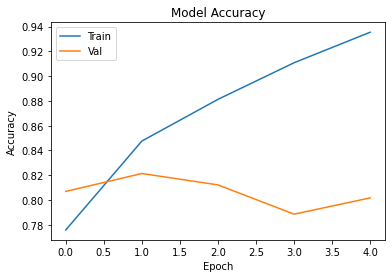

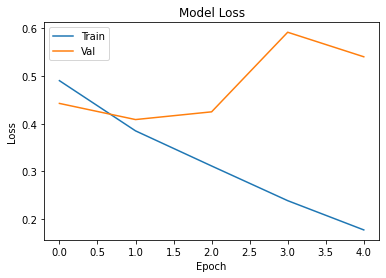

In [41]:
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train','Val'],loc='upper left')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train','Val'],loc='upper left')
plt.show()

#####  BERT model on 10 epochs

In [50]:
def build_model(bert_model):
        
    
        input_ids = tf.keras.Input(shape=(128,),dtype='int32')
        attention_masks = tf.keras.Input(shape=(128,),dtype='int32')


        output = bert_model([input_ids,attention_masks])
        output = output[1]
        output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
        optimizer = SGD(learning_rate=0.0001, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

In [51]:
model = build_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            769         tf_bert_model_1[7][1]      

In [52]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=10,
    batch_size=32)

Epoch 1/10
191/191 [==============================] - 3749s 19s/step - loss: 0.6666 - accuracy: 0.6002 - val_loss: 0.6415 - val_accuracy: 0.6835
Epoch 2/10
191/191 [==============================] - 2804s 15s/step - loss: 0.5996 - accuracy: 0.7204 - val_loss: 0.5311 - val_accuracy: 0.7702
Epoch 3/10
191/191 [==============================] - 2806s 15s/step - loss: 0.5147 - accuracy: 0.7658 - val_loss: 0.4703 - val_accuracy: 0.7853
Epoch 4/10
191/191 [==============================] - 3442s 18s/step - loss: 0.4778 - accuracy: 0.7877 - val_loss: 0.4537 - val_accuracy: 0.7886
Epoch 5/10
191/191 [==============================] - 6074s 32s/step - loss: 0.4651 - accuracy: 0.7929 - val_loss: 0.4377 - val_accuracy: 0.8096
Epoch 6/10
191/191 [==============================] - 3521s 18s/step - loss: 0.4478 - accuracy: 0.7985 - val_loss: 0.4306 - val_accuracy: 0.8096
Epoch 7/10
191/191 [==============================] - 2743s 14s/step - loss: 0.4322 - accuracy: 0.8108 - val_loss: 0.4318 - val_ac

KeyboardInterrupt: 

#### BERT on unlemmatized text

In [23]:
def build_model(bert_model):
    
    
        input_ids = tf.keras.Input(shape=(128,),dtype='int32')
        attention_masks = tf.keras.Input(shape=(128,),dtype='int32')
        
        output = bert_model([input_ids,attention_masks])
        output = output[1]
        output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
        optimizer = SGD(learning_rate=0.0001, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

In [24]:
model = build_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     multiple             109482240   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            769         tf_bert_model[1][1]        

In [25]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=5,
    batch_size=10
)

Epoch 1/5
609/609 [==============================] - 3022s 5s/step - loss: 0.5799 - accuracy: 0.6951 - val_loss: 0.4710 - val_accuracy: 0.7899
Epoch 2/5
609/609 [==============================] - 2670s 4s/step - loss: 0.4693 - accuracy: 0.7885 - val_loss: 0.4671 - val_accuracy: 0.7859
Epoch 3/5
609/609 [==============================] - 5051s 8s/step - loss: 0.4335 - accuracy: 0.8090 - val_loss: 0.4476 - val_accuracy: 0.8011
Epoch 4/5
609/609 [==============================] - 6238s 10s/step - loss: 0.4183 - accuracy: 0.8135 - val_loss: 0.4281 - val_accuracy: 0.8181
Epoch 5/5
609/609 [==============================] - 3054s 5s/step - loss: 0.4009 - accuracy: 0.8299 - val_loss: 0.4352 - val_accuracy: 0.8109


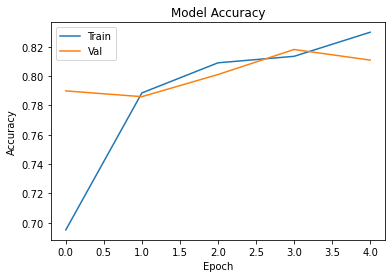

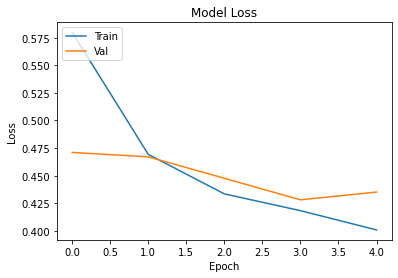

In [26]:
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train','Val'],loc='upper left')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train','Val'],loc='upper left')
plt.show()

#### 4.2 XGBoost model

##### Confusion Matrix

In [27]:
x_axes = ['Disaster', 'Non-disaster']
y_axes =  ['Non-disaster', 'Disaster']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add a title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

In [47]:
x = df_train['text']
y = df_train['target']

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


In [49]:
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
    ))
])

In [52]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

Train: 0.8081975827640567
Test: 0.773109243697479


#### 4.3 LSTM

In [19]:
train_tweets = df_train['text'].values
test_tweets = df_test['text'].values
train_target = df_train['target'].values

In [20]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

14434

In [21]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [22]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [25]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3793,  427,  221, ...,    0,    0,    0],
       [ 106,    3,  139, ...,    0,    0,    0],
       [1474, 1347, 1798, ...,    0,    0,    0],
       ...,
       [ 544, 1339,    1, ...,    0,    0,    0],
       [  18,  950, 2701, ...,    0,    0,    0],
       [ 125,   20,  450, ...,    0,    0,    0]])

In [27]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('./data/glove.6B.100d.txt', encoding="utf8") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [28]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.78276002,  0.80839002,  0.34307   , ...,  0.083831  ,
         0.47064999,  0.59265   ],
       [-0.031071  , -0.22633   , -0.18579   , ..., -0.063149  ,
        -0.60852998, -0.24131   ],
       ...,
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.25161999,  0.73246998,  0.30792999, ..., -0.89315999,
         1.29760003, -0.04898   ],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

In [29]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25)

In [57]:
# create model
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 100)           1443400   
_________________________________________________________________
bidirectional (Bidirectional (None, 23, 46)            22816     
_________________________________________________________________
global_max_pooling1d (Global (None, 46)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 46)                184       
_________________________________________________________________
dropout (Dropout)            (None, 46)                0         
_________________________________________________________________
dense (Dense)                (None, 23)                1081      
_________________________________________________________________
dropout_1 (Dropout)          (None, 23)               

In [58]:
# train model
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001)

history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint])

Epoch 1/7
179/179 [==============================] - 14s 41ms/step - loss: 0.7628 - accuracy: 0.5689 - val_loss: 0.6667 - val_accuracy: 0.7195

Epoch 00001: val_loss improved from inf to 0.66670, saving model to model.h5
Epoch 2/7
179/179 [==============================] - 7s 38ms/step - loss: 0.6378 - accuracy: 0.6521 - val_loss: 0.5471 - val_accuracy: 0.7852

Epoch 00002: val_loss improved from 0.66670 to 0.54710, saving model to model.h5
Epoch 3/7
179/179 [==============================] - 7s 37ms/step - loss: 0.5653 - accuracy: 0.7287 - val_loss: 0.4720 - val_accuracy: 0.7994

Epoch 00003: val_loss improved from 0.54710 to 0.47204, saving model to model.h5
Epoch 4/7
179/179 [==============================] - 7s 37ms/step - loss: 0.5151 - accuracy: 0.7733 - val_loss: 0.4607 - val_accuracy: 0.8004

Epoch 00004: val_loss improved from 0.47204 to 0.46070, saving model to model.h5
Epoch 5/7
179/179 [==============================] - 7s 38ms/step - loss: 0.4805 - accuracy: 0.8012 - val_l

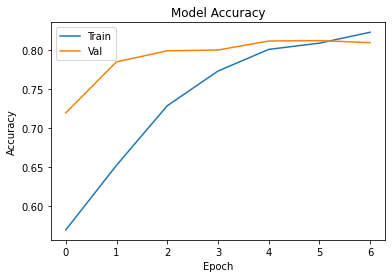

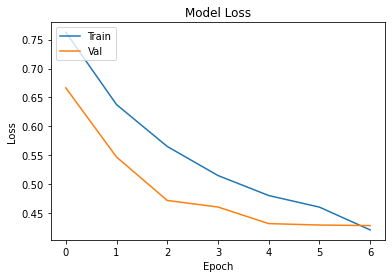

In [61]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train','Val'],loc='upper left')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train','Val'],loc='upper left')
plt.show()

##### LSTM with more features

In [57]:
train_tweet = df_train[['text', 'URL', 'number']]
test_tweet = df_test['text'].values
train_target = df_train['target']

In [54]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweet)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

4

In [55]:
longest_train = max(train_tweet, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweet), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweet), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[1],
       [2],
       [3]])

In [58]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    train_tweet, 
    train_target, 
    test_size=0.25)

In [59]:
# create model
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1, 100)            1443400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 2)              816       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 2)                 0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2)                 8         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1)                

In [60]:
# train model
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001)

history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

##### XGBoost model for 3 features

In [100]:
x = df_train[['text', 'URL', 'number']]
y = df_train['target']

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


In [87]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

In [89]:
cat_cols = x.select_dtypes(exclude="number").columns

In [90]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

In [91]:
xgb_cl = xgb.XGBClassifier()

In [94]:
# Apply preprocessing
X_processed = full_processor.fit_transform(x)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
    y.values.reshape(-1, 1)
)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, stratify=y_processed, random_state=1121218
)

In [97]:

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

#Score
accuracy_score(y_test, preds)

[14:51:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6491596638655462

##### XGBoost with all features

In [103]:
X = df_train.drop(['target'], axis=1)
y = df_train['target']

In [104]:
cat_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

In [105]:
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)

In [106]:
cat_columns = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

In [107]:
full_procesor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", cat_pipeline, cat_columns),
    ]
)

In [108]:
xgb_cls = xgb.XGBClassifier()

print(type(xgb_cls))

<class 'xgboost.sklearn.XGBClassifier'>


In [109]:
# Apply preprocessing
X_processed = full_procesor.fit_transform(X)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
    y.values.reshape(-1, 1)
)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, stratify=y_processed, random_state=1121218
)

In [111]:

# Init classifier
xgb_cls = xgb.XGBClassifier(objective="binary:logistic")

# Fit
xgb_cls.fit(X_train, y_train)

# Predict
pred = xgb_cls.predict(X_test)

# Score
accuracy_score(y_test, pred)

C:\Users\lia\anaconda3\envs\general\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\lia\anaconda3\envs\general\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\lia\anaconda3\envs\general\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[15:07:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7331932773109243